In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft

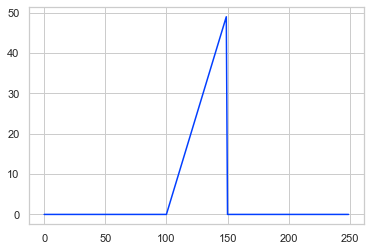

In [3]:
from scipy import signal
import math
x = np.arange(0, 250, 1)
y = np.zeros(250)
for i in range(0, 50, 1):
    y[100+i] = i
plt.plot(x, y)
plt.show()

In [4]:
#x = np.arange(1, 31, 1)
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# GMM on actual time series

In [5]:
dfx = signal_3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [6]:
print(best_gmm, '\n')
print('WEIGHTS -', best_gmm.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm.means_, '\n')

GaussianMixture(n_components=3) 

WEIGHTS - [0.19761852 0.39998852 0.40239296] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[124.79524657  24.79524657]
 [199.45923991   0.        ]
 [ 49.84366945   0.        ]] 



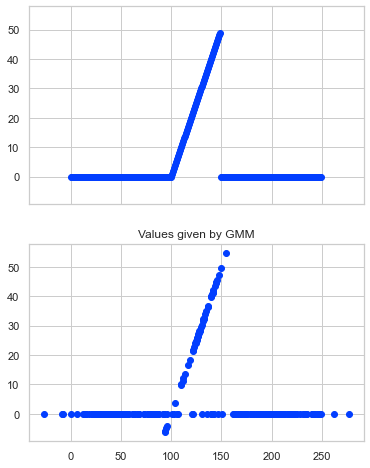

In [13]:
fig, ax = plt.subplots(2, sharex='all', sharey='all', figsize = (6,8))
z,_ = best_gmm.sample(250)
plt.title('Actual data')
ax[0].scatter(signal_3['Time'], signal_3['Value'])
plt.title('Values given by GMM')
ax[1].scatter(z[:,0],z[:,1])
plt.show()

In [16]:
from scipy.stats import wasserstein_distance
wasserstein_distance(signal_3['Value'], z[:, 1])

0.8532331343869514

# GMM on abs FFT

In [17]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data = pd.DataFrame(zip(np.abs(f[:N//2+1]),np.abs(yf[:N//2+1])),columns=['Freq','Ampli'])
    return fft_data

In [18]:
freq_ampli = freq(signal_3)

<AxesSubplot:xlabel='Freq', ylabel='Ampli'>

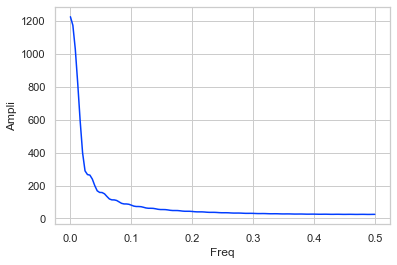

In [19]:
#plt.figure(figsize=(10,6))
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])
#plt.xlim(-0.1, 0.1)

In [20]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm1 = GMM_fit(freq_ampli)

In [21]:
print(best_gmm1, '\n')
print('WEIGHTS -', best_gmm1.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm1.means_, '\n')

GaussianMixture(n_components=16) 

WEIGHTS - [0.30830656 0.00793651 0.00793649 0.00793651 0.00793651 0.09134309
 0.048596   0.00793651 0.00793651 0.23737086 0.03174579 0.00793651
 0.02380954 0.15669703 0.00793651 0.03863908] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[4.24223058e-01 2.57594564e+01]
 [4.00000000e-03 1.17328059e+03]
 [3.60000000e-02 2.39046844e+02]
 [1.60000000e-02 5.92716335e+02]
 [1.20000000e-02 8.20512194e+02]
 [1.25265478e-01 6.51698294e+01]
 [7.03040833e-02 1.14074863e+02]
 [2.00000000e-02 3.98149278e+02]
 [8.00000000e-03 1.02861094e+03]
 [2.86821358e-01 3.20088621e+01]
 [4.99999883e-02 1.58276746e+02]
 [0.00000000e+00 1.22500000e+03]
 [2.80000048e-02 2.72944604e+02]
 [1.87452237e-01 4.52429461e+01]
 [4.00000000e-02 1.99468244e+02]
 [9.21619025e-02 8.69455133e+01]] 



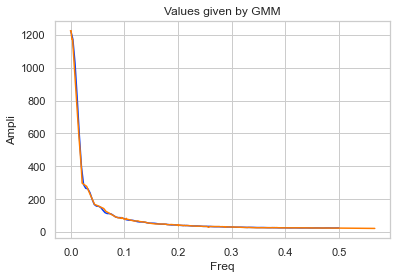

In [22]:
z2,_ = best_gmm1.sample(126)
plt.title('Actual data')
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(z2[:,0],z2[:,1])
plt.show()

In [23]:
wasserstein_distance(freq_ampli['Ampli'], z2[:, 1])

11.861054067905602

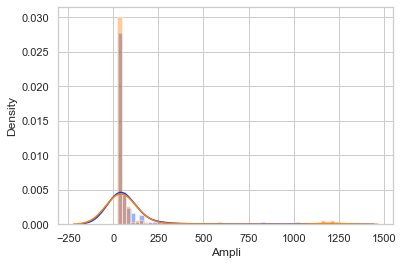

In [24]:
sns.distplot(freq_ampli['Ampli'], kde = True)
sns.distplot(z2[:, 1], kde = True)
plt.show()

# GMM on FFT of actual time series

In [25]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_real,freq_ampli_img
freq_ampli3,freq_ampli3i = freq(signal_3)

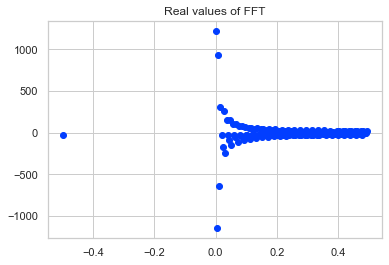

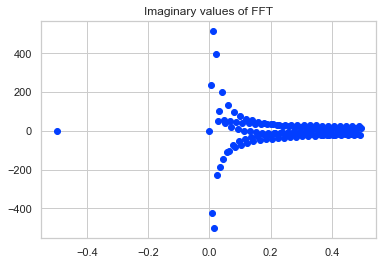

In [26]:
plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.title('Real values of FFT')
plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [27]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [28]:
best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [29]:
print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')

GaussianMixture(n_components=25) 

WEIGHTS - [0.19839772 0.00793651 0.00793651 0.00793651 0.00793651 0.07184248
 0.00793651 0.00793651 0.04342017 0.0718772  0.01587302 0.07872856
 0.04706816 0.00793651 0.05526125 0.00793651 0.04161856 0.01587302
 0.00793651 0.04766154 0.00793651 0.05453928 0.05803762 0.031787
 0.08864934] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.19997853e-01 -2.50000000e+01]
 [ 0.00000000e+00  1.22500000e+03]
 [ 4.00000000e-03 -1.14907463e+03]
 [ 2.80000000e-02  2.61872315e+02]
 [ 1.20000000e-02 -6.38115554e+02]
 [ 3.96986221e-01  2.53067749e+01]
 [ 2.40000000e-02 -1.74298720e+02]
 [ 8.00000000e-03  9.38108789e+02]
 [ 9.99539032e-02  6.64352932e+01]
 [ 1.49545620e-01 -5.79305568e+01]
 [ 4.20000000e-02  1.49174953e+02]
 [ 4.12651935e-01  1.59775083e+01]
 [ 2.53520382e-01  5.52191754e+00]
 [ 3.20000000e-02 -2.43436485e+02]
 [ 2.68415938e-01 -2.88564955e+01]
 [ 1.60000000e-02  3.12319574e+02]
 [ 1.57609814e-01  4.08013794e+01]
 [ 6.20000000e-02  1.02381039e+02]
 [

In [30]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=27) 

WEIGHTS - [0.01587295 0.00793651 0.09464138 0.00793651 0.00793651 0.09349331
 0.00793651 0.00793651 0.01587302 0.04216787 0.01587302 0.00793651
 0.01587256 0.07108218 0.00793651 0.00793651 0.00793651 0.00793651
 0.08928777 0.08850371 0.11377208 0.00793651 0.21657604 0.01587302
 0.00793651 0.00793651 0.00793651] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 9.00000443e-02 -7.25900940e+01]
 [ 4.00000000e-03  2.37096682e+02]
 [ 3.78687141e-01  2.64583648e+01]
 [ 1.60000000e-02 -5.03755038e+02]
 [ 1.20000000e-02  5.15799186e+02]
 [ 3.92370002e-01 -2.03667527e+01]
 [ 2.40000000e-02 -2.30638938e+02]
 [ 2.00000000e-02  3.97363621e+02]
 [ 5.60000000e-02  9.86949983e+01]
 [ 3.53519847e-04  1.27536548e+00]
 [ 6.00000000e-02 -1.07617011e+02]
 [ 8.00000000e-03 -4.21891419e+02]
 [ 1.05999207e-01  4.32723559e+01]
 [ 3.73925802e-01 -2.29133822e+01]
 [ 3.60000000e-02 -1.86448975e+02]
 [ 4.00000000e-02  1.97895377e+02]
 [ 4.40000000e-02 -1.44599323e+02]
 [ 6.00000000

In [31]:
#Sampling
z1,_ = best_gmm0.sample(126)
z1i,_ = best_gmm0i.sample(126)

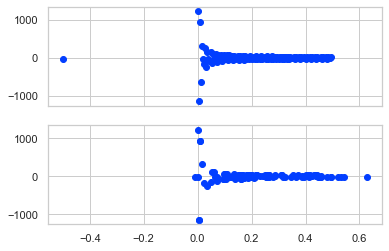

In [32]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()

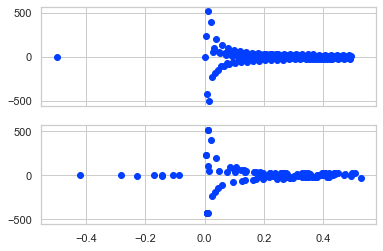

In [33]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [34]:
print('Real: ', wasserstein_distance(freq_ampli3['Ampli'], z1[:, 1]))
print('Imag: ', wasserstein_distance(freq_ampli3i['Ampli'], z1i[:, 1]))

Real:  14.174162587187663
Imag:  16.017836500672516


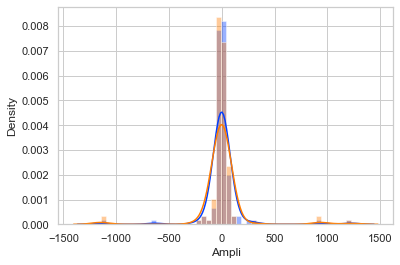

In [35]:
sns.distplot(freq_ampli3['Ampli'], kde = True)
sns.distplot(z1[:, 1], kde = True)
plt.show()

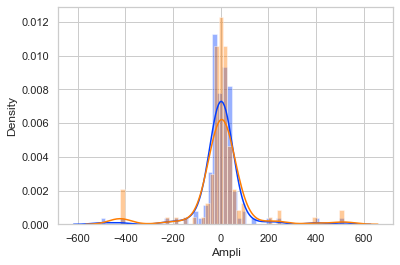

In [36]:
sns.distplot(freq_ampli3i['Ampli'], kde = True)
sns.distplot(z1i[:, 1], kde = True)
plt.show()

In [37]:
sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [38]:
sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [39]:
#sample_1 = sample_1[(sample_1.Ampli>1) | (sample_1.Ampli<-1)]
#sample_1i = sample_1i[(sample_1i.Ampli>1) | (sample_1i.Ampli<-1)]

In [40]:
f = fftpack.fftfreq(250)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [41]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [42]:
sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [43]:
samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [44]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd

{0.0: -25.00015088989932,
 0.004: -1149.0754711240866,
 0.008: 938.1098908209862,
 0.012: 0.0,
 0.016: 312.3197359376348,
 0.02: 0.0,
 0.024: -174.29846760961536,
 0.028: 0.0,
 0.032: -243.43714176619974,
 0.036: 0.0,
 0.04: 0.0,
 0.044: 0.0,
 0.048: 0.0,
 0.052: 103.13556412318093,
 0.056: 0.0,
 0.06: 102.8343871332853,
 0.064: -24.99809562511237,
 0.068: 0.0,
 0.072: -111.04263271400468,
 0.076: 0.0,
 0.08: 0.0,
 0.084: 0.0,
 0.088: 0.0,
 0.092: -75.01727091195895,
 0.096: 0.0,
 0.1: 62.62107958978554,
 0.104: -22.821784805567752,
 0.108: -26.159712078757572,
 0.112: -24.998644727320187,
 0.116: -21.600508768341253,
 0.12: -16.815725497676517,
 0.124: -24.999743525796582,
 0.128: -25.000713336463875,
 0.132: 0.0,
 0.136: 56.86882308250627,
 0.14: -66.17734792005804,
 0.144: -11.310977163825388,
 0.148: 0.0,
 0.152: 46.13494667945709,
 0.156: -25.00221480949397,
 0.16: -58.93612847841586,
 0.164: 32.86664169643996,
 0.168: 37.104139641759694,
 0.172: -52.51843569462847,
 0.176: 0.0,
 

In [45]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: -25.00015088989932,
 0.004: (-1149.0754711240866+474.19216319364546j),
 0.008: (938.1098908209862-1265.6714947852556j),
 0.012: 1031.5991641731657j,
 0.016: 312.3197359376348,
 0.02: 397.36362084716995j,
 0.024: (-174.29846760961536-230.63976616562582j),
 0.028: 0.0,
 0.032: -243.43714176619974,
 0.036: -186.449695646514j,
 0.04: 197.8942261686291j,
 0.044: -144.5996600710069j,
 0.048: 0.0,
 0.052: 103.13556412318093,
 0.056: 0.0,
 0.06: 102.8343871332853,
 0.064: -24.99809562511237,
 0.068: 0.0,
 0.072: -111.04263271400468,
 0.076: 42.05536909670674j,
 0.08: 0.0,
 0.084: 0.0,
 0.088: 0.0,
 0.092: -75.01727091195895,
 0.096: -72.18076101913697j,
 0.1: (62.62107958978554+153.88535644803514j),
 0.104: (-22.821784805567752+138.46840433317394j),
 0.108: -26.159712078757572,
 0.112: -24.998644727320187,
 0.116: -21.600508768341253,
 0.12: -16.815725497676517,
 0.124: (-24.999743525796582+3.4285480301987192j),
 0.128: -25.000713336463875,
 0.132: 0.0,
 0.136: (56.86882308250627+41.3936

In [46]:
value = list(sd.values())

# Final IFFT 

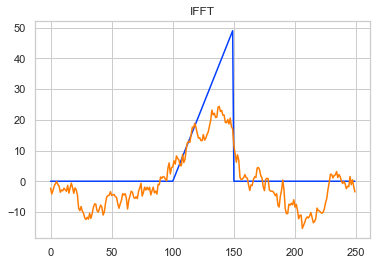

In [47]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)

# Log freq

<AxesSubplot:xlabel='Freq', ylabel='Ampli'>

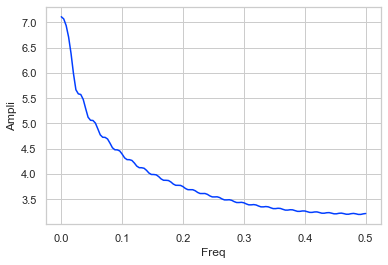

In [48]:
log_ampli = np.log(freq_ampli["Ampli"])
log_freq_ampli= pd.DataFrame(zip(freq_ampli['Freq'],log_ampli),columns=['Freq','Ampli'])
log_freq_ampli = log_freq_ampli.loc[log_freq_ampli['Ampli'] != float('-inf')]
sns.lineplot(log_freq_ampli['Freq'], log_freq_ampli['Ampli'])

In [49]:
dfx = log_freq_ampli
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm2 = gmm

In [50]:
print(best_gmm2, '\n')
print('WEIGHTS -', best_gmm2.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm2.means_, '\n')

GaussianMixture(n_components=7) 

WEIGHTS - [0.12059976 0.29977075 0.03969028 0.04988568 0.16687958 0.24079343
 0.0823805 ] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[0.11512688 4.26087007]
 [0.42632048 3.24609424]
 [0.00800238 6.84160469]
 [0.03072133 5.57417872]
 [0.18760348 3.80601316]
 [0.29023151 3.45389785]
 [0.06402138 4.83779766]] 



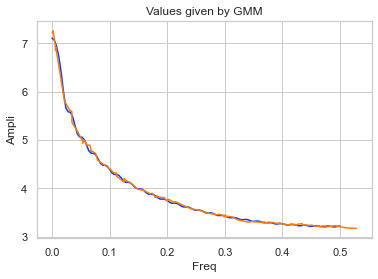

In [51]:
z2,_ = best_gmm2.sample(125)
plt.title('Actual data')
sns.lineplot(log_freq_ampli['Freq'], log_freq_ampli['Ampli'])
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(z2[:,0],z2[:,1])
plt.show()

In [52]:
wasserstein_distance(log_freq_ampli['Ampli'], z2[:, 1])

0.10216689053869034

# Cepstrum

<AxesSubplot:xlabel='Quefrency', ylabel='Cepstrum'>

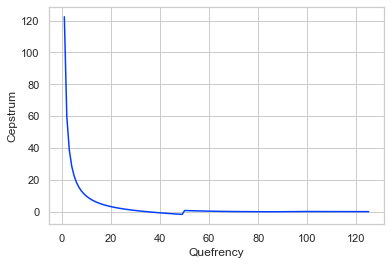

In [53]:
frame_size = signal_3.shape[0]
Fs = 1
dt = 1/Fs
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
y = np.array(signal_3['Value'])
yf = fftpack.fft(y)
yf1 = yf[yf != 0]
quefrency = np.fft.rfftfreq(np.log(yf1).size,freq_vector[1] - freq_vector[0])
cepstrum = np.fft.rfft(np.log(np.abs(yf1)))
cep = pd.DataFrame(zip(quefrency,cepstrum.real),columns=['Quefrency','Cepstrum'])
cep = cep.iloc[1:,:]
sns.lineplot(cep.Quefrency,cep.Cepstrum)

In [54]:
dfx = cep
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm3 = gmm

In [55]:
print(best_gmm3, '\n')
print('WEIGHTS -', best_gmm3.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm3.means_, '\n')

GaussianMixture(n_components=22) 

WEIGHTS - [0.06397794 0.08744737 0.05602789 0.008      0.03200045 0.0639503
 0.008      0.05590915 0.05742957 0.06395547 0.04800793 0.008
 0.06396312 0.06440847 0.03880179 0.04800001 0.05605558 0.024
 0.04000527 0.008      0.04800298 0.05605671] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 5.34996068e+01  5.30182442e-01]
 [ 1.04818772e+02  3.33261133e-02]
 [ 3.20043305e+01  3.69717937e-01]
 [ 2.00000000e+00  5.99228968e+01]
 [ 9.50003582e+00  1.05601300e+01]
 [ 7.64963774e+01 -3.59417450e-02]
 [ 1.00000000e+00  1.22448926e+02]
 [ 9.09947257e+01 -4.63400400e-02]
 [ 1.21883286e+02 -1.53863487e-02]
 [ 3.95025838e+01 -6.91127734e-01]
 [ 1.95013252e+01  3.36397045e+00]
 [ 4.00000000e+00  2.86197737e+01]
 [ 6.85024688e+01  7.86555630e-02]
 [ 1.14292807e+02 -1.69920806e-03]
 [ 9.69266286e+01  2.58722471e-02]
 [ 4.64993528e+01 -1.49888005e+00]
 [ 8.39965263e+01 -7.39130989e-02]
 [ 6.00000002e+00  1.85452282e+01]
 [ 1.40004695e+01  6.10196348e+00]
 [ 3.00000

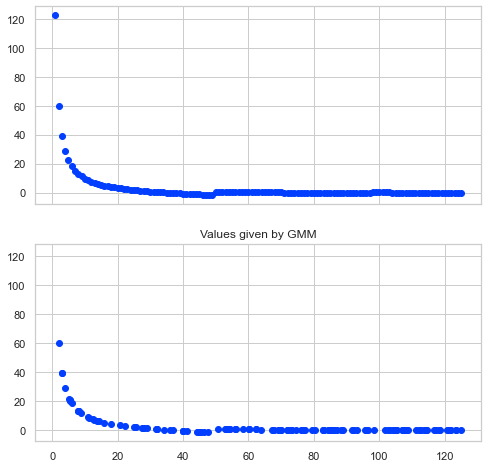

In [56]:
fig, ax = plt.subplots(2, sharex='all', sharey='all', figsize = (8, 8))
z3,_ = best_gmm3.sample(125)
plt.title('Actual data')
ax[0].scatter(cep['Quefrency'], cep['Cepstrum'])
#plt.show()
plt.title('Values given by GMM')
ax[1].scatter(z3[:,0],z3[:,1])
plt.show()

In [57]:
wasserstein_distance(cep['Cepstrum'], z3[:, 1])

1.161025965867331